# Model Robustness

**Objectives**
- Load the Model(s)
- Run predictions on the model using the Holdout/Test Datasplit (better if the malicious samples are verified for malware types)
- Record instances where the model failed to predict correctly
- Record the performance of the models (e.g., Accuracy, Precision, Recall, ROC-AUC, etc.)

In [87]:
import pandas as pd
import numpy as np

import lightgbm as lgbm
import catboost as catb

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay

from joblib import load

## 0. Defining a helper function


In [71]:
def evaluate(model, test_set, y_actual):
    y_pred = model.predict(test_set)
    cm = confusion_matrix(y_actual, y_pred)
    print(classification_report(y_actual, y_pred, digits=4))
    print("AUC-ROC Score: " + str(roc_auc_score(y_actual, y_pred)))
    print("ROC Curve & Confusion matrix:")
    RocCurveDisplay.from_predictions(y_actual, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    
    #print(classification_report(y_actual, y_pred, digits=4))
    

## 1. Determine the Model Performance in each of the GBDT Models and each of its two behavior-types.

`How does the model perform using 'real-world' data (i.e., Test/Holdout Split)?`

Run other metrics as well as you see fit that are not found in the classification_report and Confusion Matrix.

- Label column is `0/'malicious'`
- Feature column is `[:, 1:101]`

### 1.1 LightGBM

In [10]:
DF_LGBM_TB = pd.read_csv('Dataset/LGBM_TB_Test.csv', low_memory=False) #<== Point these to the proper Test/Holdout datasets.
DF_LGBM_IB = pd.read_csv('Dataset/LGBM_IB_Test.csv', low_memory=False)

display(DF_LGBM_TB.head())
display(DF_LGBM_IB.head())

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash
0,1,154,177,191,154,177,191,154,134,135,...,135,141,136,135,136,135,136,135,134,f0f8ba4c3d750a4ce2deea48152a33d4
1,1,254,209,134,136,135,136,135,136,135,...,97,92,232,136,135,236,219,232,236,39b2d87c1adb582fbcacc3a56e274d48
2,1,95,153,170,153,134,135,134,153,262,...,134,135,134,135,153,134,135,180,154,429236cdeb63d68bf48a3b48b0a34612
3,1,231,177,191,154,177,191,154,184,139,...,97,156,159,174,154,94,153,16,97,46079cbf0bcfe8fab9894b4ec88bece3
4,1,95,136,135,136,135,136,135,136,135,...,95,232,236,232,236,232,236,232,236,303ceda3f52afa9b69ed4f97fec2c895


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash
0,1,154,177,191,134,135,93,153,232,56,...,148,148,148,148,148,148,148,148,148,f0f8ba4c3d750a4ce2deea48152a33d4
1,1,254,209,134,136,135,181,174,232,236,...,148,148,148,148,148,148,148,148,148,39b2d87c1adb582fbcacc3a56e274d48
2,1,95,153,170,134,135,262,136,231,235,...,148,148,148,148,148,148,148,148,148,429236cdeb63d68bf48a3b48b0a34612
3,1,231,177,191,154,184,139,153,134,135,...,148,148,148,148,148,148,148,148,148,46079cbf0bcfe8fab9894b4ec88bece3
4,1,95,136,135,134,262,28,177,191,154,...,148,148,148,148,148,148,148,148,148,303ceda3f52afa9b69ed4f97fec2c895


In [73]:
# Load trained LightGBM model files
default_tb = load('Models/LGBM/Train_Default/DEMO_LGBM_TB.model') # <== Point these to the respective .model files
default_ib = load('Models/LGBM/Train_Default/DEMO_LGBM_IB.model')
tuned_tb = load('Models/LGBM/Train_Tuned/TUNED_DEMO_LGBM_TB.model')
tuned_ib = load('Models/LGBM/Train_Tuned/TUNED_DEMO_LGBM_IB.model')

/home/jupyter-jose_miguel_escalo-c817a/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1. Default LGBM TB: DF_LGBM_TB & default_tb

[LightGBM] [Warning] Unknown parameter: categorical_data
              precision    recall  f1-score   support

           0     0.9194    0.5481    0.6867       104
           1     0.9891    0.9988    0.9940      4284

    accuracy                         0.9881      4388
   macro avg     0.9542    0.7735    0.8404      4388
weighted avg     0.9875    0.9881    0.9867      4388

AUC-ROC Score: 0.7734548947784242
ROC Curve & Confusion matrix:


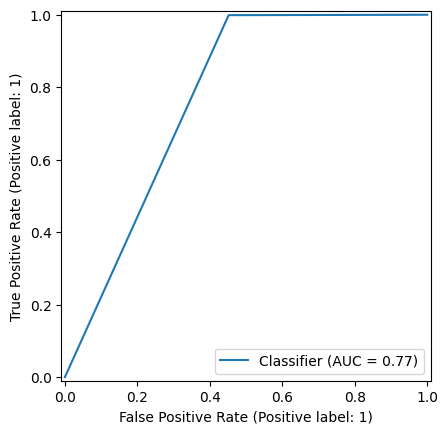

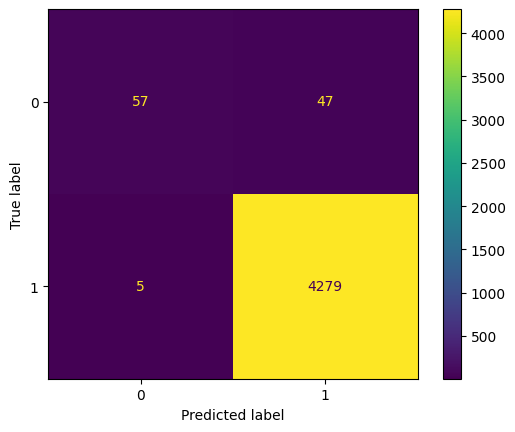

In [74]:
print("1. Default LGBM TB\n")
evaluate(default_tb, DF_LGBM_TB.iloc[:,1:101], DF_LGBM_TB.iloc[:,0])

2. Default LGBM IB: DF_LGBM_IB & default_ib

[LightGBM] [Warning] Unknown parameter: categorical_data
              precision    recall  f1-score   support

           0     0.8904    0.6250    0.7345       104
           1     0.9910    0.9981    0.9945      4284

    accuracy                         0.9893      4388
   macro avg     0.9407    0.8116    0.8645      4388
weighted avg     0.9886    0.9893    0.9884      4388

AUC-ROC Score: 0.8115662931839402
ROC Curve & Confusion matrix:


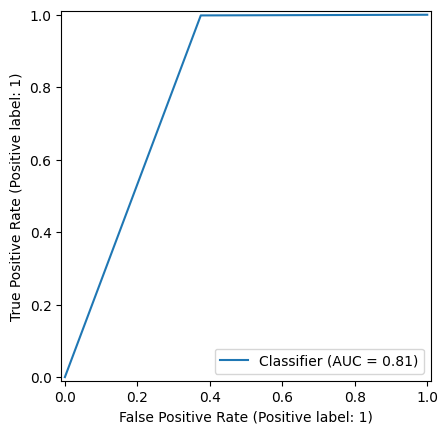

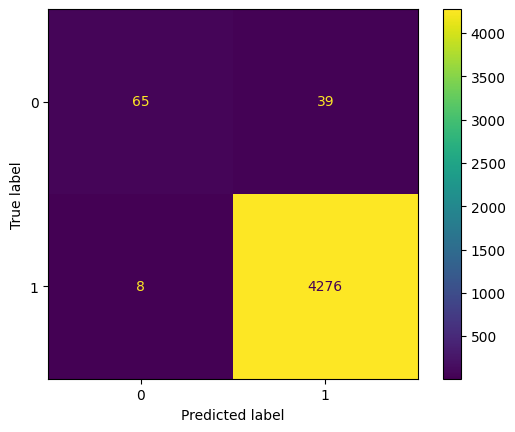

In [75]:
print("2. Default LGBM IB\n")
evaluate(default_ib, DF_LGBM_IB.iloc[:,1:101], DF_LGBM_IB.iloc[:,0])

3. Tuned LGBM TB: DF_LGBM_TB & tuned_tb

              precision    recall  f1-score   support

           0     0.9016    0.5288    0.6667       104
           1     0.9887    0.9986    0.9936      4284

    accuracy                         0.9875      4388
   macro avg     0.9452    0.7637    0.8301      4388
weighted avg     0.9866    0.9875    0.9859      4388

AUC-ROC Score: 0.7637227968110321
ROC Curve & Confusion matrix:


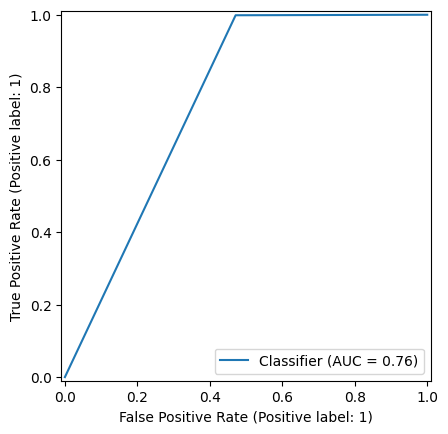

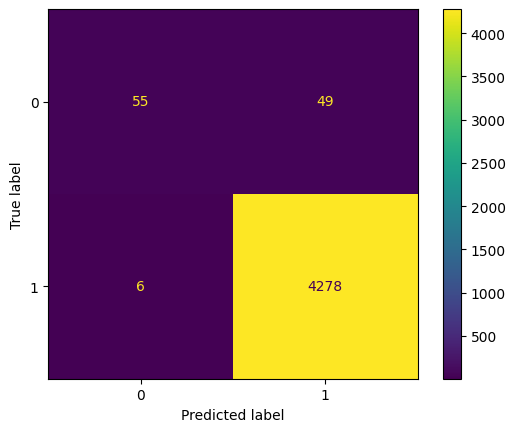

In [78]:
print("3. Tuned LGBM TB\n")
evaluate(tuned_tb, DF_LGBM_TB.iloc[:,1:101], DF_LGBM_TB.iloc[:,0])

4. Tuned LGBM IB: DF_LGBM_IB & tuned_ib

              precision    recall  f1-score   support

           0     0.8182    0.5192    0.6353       104
           1     0.9884    0.9972    0.9928      4284

    accuracy                         0.9859      4388
   macro avg     0.9033    0.7582    0.8140      4388
weighted avg     0.9844    0.9859    0.9843      4388

AUC-ROC Score: 0.758214824391295
ROC Curve & Confusion matrix:


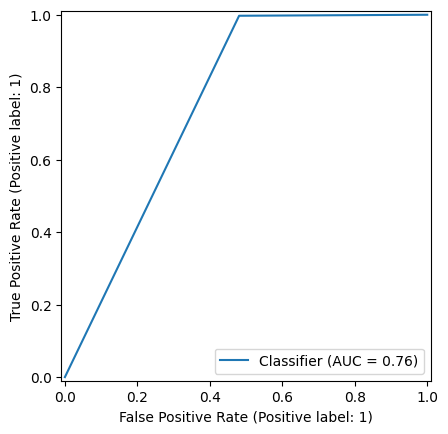

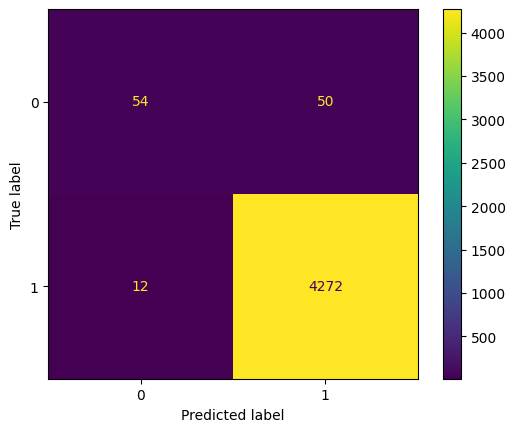

In [79]:
print("4. Tuned LGBM IB\n")
evaluate(tuned_ib, DF_LGBM_IB.iloc[:,1:101], DF_LGBM_IB.iloc[:,0])

### 1.2 CatBoost

In [ ]:
DF_CATB_TB = pd.read_csv('Dataset/CATB_TB_Test.csv', low_memory=False) #<== Point these to the proper Test/Holdout datasets.
DF_CATB_IB = pd.read_csv('Dataset/CATB_IB_Test.csv', low_memory=False)

DF_CATB_IB.iloc[:,1:101] = DF_CATB_IB.iloc[:,1:101].astype('str')
DF_CATB_IB.replace("nan", "NaN", inplace=True)

DF_CATB_TB = DF_CATB_TB[DF_CATB_TB['Type 1'] != '_']
DF_CATB_IB = DF_CATB_IB[DF_CATB_IB['Type 1'] != '_']

display(DF_CATB_TB.head())
display(DF_CATB_IB.head())

In [95]:
# Load trained CatBoost model files (CatBoost requires instantiation before being able to load a trianed model file).
default_tb = catb.CatBoostClassifier()
default_ib = catb.CatBoostClassifier()
tuned_tb = catb.CatBoostClassifier()
tuned_ib = catb.CatBoostClassifier()
default_tb = default_tb.load_model("Models/CATB/Train_Default/DEMO_CATB_TB.model", format='json') # <== Point these to the respective .model files
default_ib = default_ib.load_model("Models/CATB/Train_Default/DEMO_CATB_IB.model", format='json')
tuned_tb = tuned_tb.load_model("Models/CATB/Train_Tuned/TUNED_DEMO_CATB_TB.model", format='json')
tuned_ib = tuned_ib.load_model("Models/CATB/Train_Tuned/TUNED_DEMO_CATB_IB.model", format='json')

1. Default CatBoost TB

              precision    recall  f1-score   support

           0     0.9524    0.5769    0.7186       104
           1     0.9898    0.9993    0.9945      4284

    accuracy                         0.9893      4388
   macro avg     0.9711    0.7881    0.8566      4388
weighted avg     0.9889    0.9893    0.9880      4388

AUC-ROC Score: 0.788111398405516
ROC Curve & Confusion matrix:


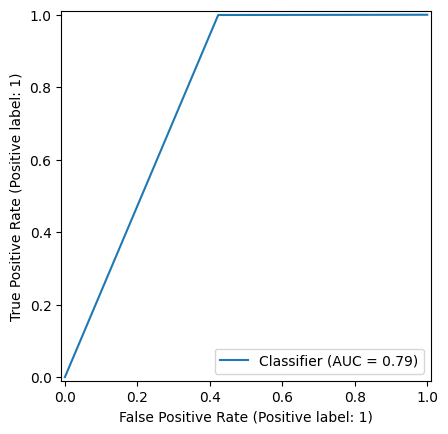

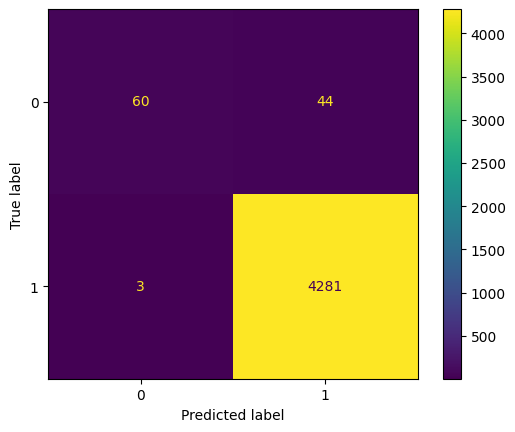

In [91]:
print("1. Default CatBoost TB\n")
evaluate(default_tb, DF_CATB_TB.iloc[:,1:101], DF_CATB_TB.iloc[:,0])

2. Default CatBoost IB

              precision    recall  f1-score   support

           0     0.9189    0.6538    0.7640       104
           1     0.9917    0.9986    0.9951      4284

    accuracy                         0.9904      4388
   macro avg     0.9553    0.8262    0.8796      4388
weighted avg     0.9899    0.9904    0.9896      4388

AUC-ROC Score: 0.8262227968110321
ROC Curve & Confusion matrix:


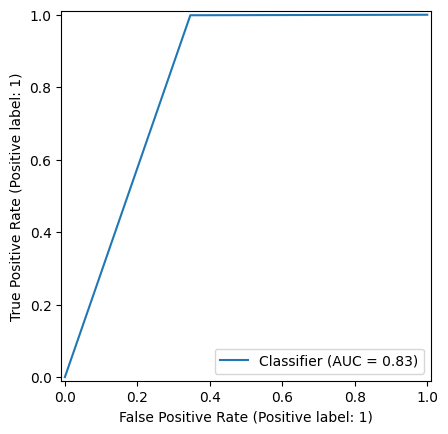

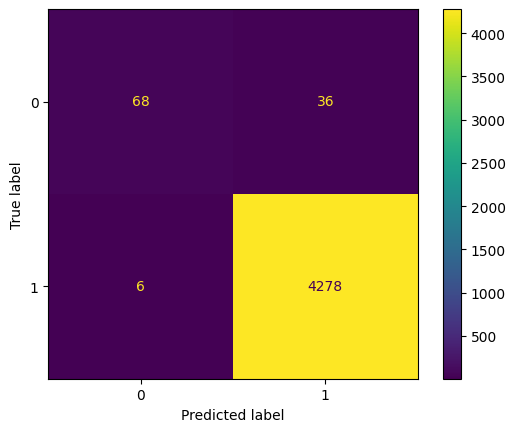

In [92]:
print("2. Default CatBoost IB\n")
evaluate(default_ib, DF_CATB_IB.iloc[:,1:101], DF_CATB_IB.iloc[:,0])

3. Tuned CatBoost TB

              precision    recall  f1-score   support

           0     0.9394    0.5962    0.7294       104
           1     0.9903    0.9991    0.9947      4284

    accuracy                         0.9895      4388
   macro avg     0.9648    0.7976    0.8620      4388
weighted avg     0.9891    0.9895    0.9884      4388

AUC-ROC Score: 0.7976100696688933
ROC Curve & Confusion matrix:


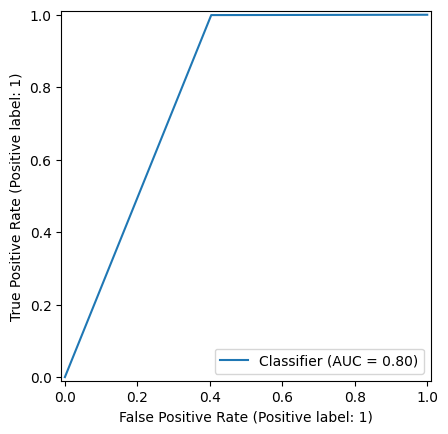

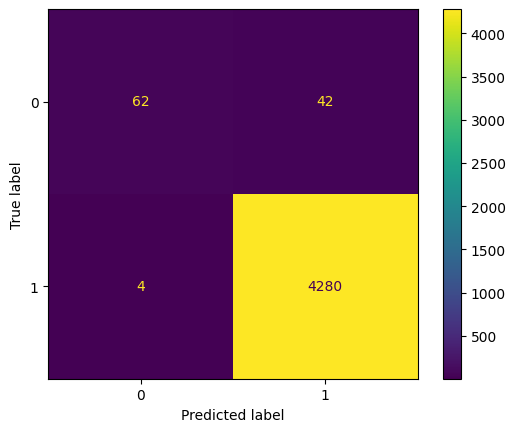

In [93]:
print("3. Tuned CatBoost TB\n")
evaluate(tuned_tb, DF_CATB_TB.iloc[:,1:101], DF_CATB_TB.iloc[:,0])

4. Tuned CatBoost IB

              precision    recall  f1-score   support

           0     0.9242    0.5865    0.7176       104
           1     0.9901    0.9988    0.9944      4284

    accuracy                         0.9891      4388
   macro avg     0.9571    0.7927    0.8560      4388
weighted avg     0.9885    0.9891    0.9879      4388

AUC-ROC Score: 0.7926856640091934
ROC Curve & Confusion matrix:


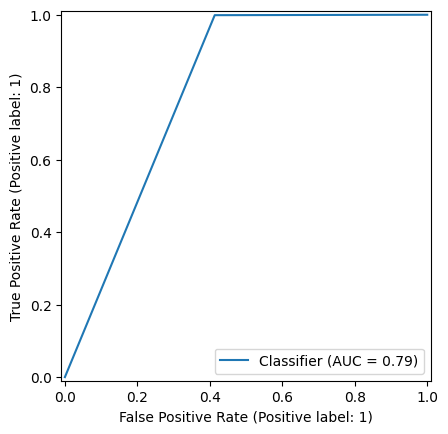

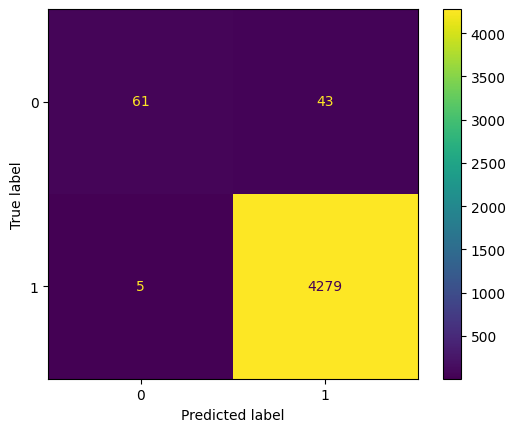

In [94]:
print("4. Tuned CatBoost IB\n")
evaluate(tuned_ib, DF_CATB_IB.iloc[:,1:101], DF_CATB_IB.iloc[:,0])

## 2. Check for model capabilities at a malware type level in each GBDT Models and each of its two behavior-types.

Using the `xx` dataset, determine the prediction capability of the model in each malware type.

**Answer this question:**

`How good are the model (as per classification report and confusion matrix) on a per-malware type basis?`

The theory is that malware-types that are prominent in terms of quantity might be detected accurately as malware than those that are not. 

### 2.1 LightGBM

In [6]:
#Load Verified Test/Holodut Dataset
DF_LGBM_TB = pd.read_csv('../Dataset/Valid_Mali_Test/LGBM_TB_Test_Malicious.csv', low_memory=False)
DF_LGBM_IB = pd.read_csv('../Dataset/Valid_Mali_Test/LGBM_IB_Test_Malicious.csv', low_memory=False)
DF_LGBM_TB = DF_LGBM_TB[DF_LGBM_TB['Type 1'] != '_']
DF_LGBM_IB = DF_LGBM_IB[DF_LGBM_IB['Type 1'] != '_']

#Models
default_tb = load('../GBDT_Training/Outputs/Results/Demo/LGBM/Train (Default)/DEMO_LGBM_TB.model')
default_ib = load('../GBDT_Training/Outputs/Results/Demo/LGBM/Train (Default)/DEMO_LGBM_IB.model')
tuned_tb = load('../GBDT_Training/Outputs/Results/Demo/LGBM/Train (Tuned)/TUNED_DEMO_LGBM_TB.model')
tuned_ib = load('../GBDT_Training/Outputs/Results/Demo/LGBM/Train (Tuned)/TUNED_DEMO_LGBM_IB.model')

display(DF_LGBM_TB)
print("DF_LGBM_TB:", DF_LGBM_TB['Type 1'].unique().tolist())
display(DF_LGBM_IB)
print("DF_LGBM_IB:", DF_LGBM_IB['Type 1'].unique().tolist())

'''
COLUMNS:
Features = [:, 1:101]
Label = [:, 0]
Hash = [:, 101]
Type 1 (malware type) = [:, 102]
'''

c:\Users\ejose\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_94,t_95,t_96,t_97,t_98,t_99,hash,Type 1,Type 2,Type 3
0,1,154,177,191,154,177,191,154,134,135,...,135,136,135,136,135,134,f0f8ba4c3d750a4ce2deea48152a33d4,trojan,adware,_
1,1,254,209,134,136,135,136,135,136,135,...,136,135,236,219,232,236,39b2d87c1adb582fbcacc3a56e274d48,downloader,trojan,_
2,1,95,153,170,153,134,135,134,153,262,...,135,153,134,135,180,154,429236cdeb63d68bf48a3b48b0a34612,downloader,adware,trojan
3,1,231,177,191,154,177,191,154,184,139,...,174,154,94,153,16,97,46079cbf0bcfe8fab9894b4ec88bece3,trojan,adware,_
4,1,95,136,135,136,135,136,135,136,135,...,232,236,232,236,232,236,303ceda3f52afa9b69ed4f97fec2c895,trojan,adware,_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4278,1,231,177,191,154,177,191,154,184,139,...,72,162,72,162,72,162,46717ed2b7acc16fd7a74190caa723ed,trojan,_,_
4279,1,95,136,135,136,135,81,135,134,135,...,135,136,135,93,136,135,ace1fb315abc4e4a10624c8b03f917aa,trojan,adware,_
4280,1,136,135,136,135,136,135,136,135,136,...,138,59,138,59,138,59,f8948ed47902c6400b086a867685c107,trojan,adware,_
4281,1,95,136,135,136,135,136,135,136,135,...,232,236,232,236,232,236,131e9e0e7ce851fd4be463c32e025c7b,trojan,adware,pua


DF_LGBM_TB: ['trojan', 'downloader', 'adware', 'ransomware', 'pua', 'hacktool', 'virus', 'miner']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_94,t_95,t_96,t_97,t_98,t_99,hash,Type 1,Type 2,Type 3
0,1,154,177,191,134,135,93,153,232,56,...,148,148,148,148,148,148,f0f8ba4c3d750a4ce2deea48152a33d4,trojan,adware,_
1,1,254,209,134,136,135,181,174,232,236,...,148,148,148,148,148,148,39b2d87c1adb582fbcacc3a56e274d48,downloader,trojan,_
2,1,95,153,170,134,135,262,136,231,235,...,148,148,148,148,148,148,429236cdeb63d68bf48a3b48b0a34612,downloader,adware,trojan
3,1,231,177,191,154,184,139,153,134,135,...,148,148,148,148,148,148,46079cbf0bcfe8fab9894b4ec88bece3,trojan,adware,_
4,1,95,136,135,134,262,28,177,191,154,...,148,148,148,148,148,148,303ceda3f52afa9b69ed4f97fec2c895,trojan,adware,_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4278,1,231,177,191,154,184,139,153,134,135,...,148,148,148,148,148,148,46717ed2b7acc16fd7a74190caa723ed,trojan,_,_
4279,1,95,136,135,81,134,262,154,177,191,...,148,148,148,148,148,148,ace1fb315abc4e4a10624c8b03f917aa,trojan,adware,_
4280,1,136,135,183,154,177,191,134,93,153,...,148,148,148,148,148,148,f8948ed47902c6400b086a867685c107,trojan,adware,_
4281,1,95,136,135,134,262,28,177,191,154,...,148,148,148,148,148,148,131e9e0e7ce851fd4be463c32e025c7b,trojan,adware,pua


DF_LGBM_IB: ['trojan', 'downloader', 'adware', 'ransomware', 'pua', 'hacktool', 'virus', 'miner']


'\nCOLUMNS:\nFeatures = [:, 1:101]\nLabel = [:, 0]\nHash = [:, 101]\nType 1 (malware type) = [:, 102]\n'

In [7]:
'''
WRITE THE PREDICT AND VISUALIZE CODE HERE:

1. Default LGBM TB: DF_LGBM_TB & default_tb
2. Default LGBM IB: DF_LGBM_IB & default_ib
3. Tuned LGBM IB: DF_LGBM_TB & tuned_tb
4. Tuned LGBM IB: DF_LGBM_IB & tuned_ib
'''

'\nWRITE THE PREDICT AND VISUALIZE CODE HERE:\n\n1. Default LGBM TB: DF_LGBM_TB & default_tb\n2. Default LGBM IB: DF_LGBM_IB & default_ib\n3. Tuned LGBM IB: DF_LGBM_TB & tuned_tb\n4. Tuned LGBM IB: DF_LGBM_IB & tuned_ib\n'

### 2.2 CatBoost

In [8]:
#Load Verified Test/Holdout Dataset
DF_CATB_TB = pd.read_csv('../Dataset/Valid_Mali_Test/CATB_TB_Test_Malicious.csv', low_memory=False)
DF_CATB_IB = pd.read_csv('../Dataset/Valid_Mali_Test/CATB_IB_Test_Malicious.csv', low_memory=False)

DF_CATB_TB = DF_CATB_TB[DF_CATB_TB['Type 1'] != '_']
DF_CATB_IB = DF_CATB_IB[DF_CATB_IB['Type 1'] != '_']

default_tb = catb.CatBoostClassifier()
default_ib = catb.CatBoostClassifier()
tuned_tb = catb.CatBoostClassifier()
tuned_ib = catb.CatBoostClassifier()
default_tb = default_tb.load_model("../GBDT_Training/Outputs/Results/Demo/CATB/Train (Default)/DEMO_CATB_TB.model", format='json')
default_ib = default_ib.load_model("../GBDT_Training/Outputs/Results/Demo/CATB/Train (Default)/DEMO_CATB_IB.model", format='json')
tuned_tb = tuned_tb.load_model("../GBDT_Training/Outputs/Results/Demo/CATB/Train (Tuned)/TUNED_DEMO_CATB_TB.model", format='json')
tuned_ib = tuned_ib.load_model("../GBDT_Training/Outputs/Results/Demo/CATB/Train (Tuned)/TUNED_DEMO_CATB_IB.model", format='json')

display(DF_CATB_TB)
print("DF_CATB_TB:", DF_CATB_TB['Type 1'].unique().tolist())
display(DF_CATB_IB)
print("DF_CATB_IB:", DF_CATB_IB['Type 1'].unique().tolist())

'''
COLUMNS:
Features = [:, 1:101]
Label = [:, 0]
Hash = [:, 101]
Type 1 (malware type) = [:, 102]
'''

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_94,t_95,t_96,t_97,t_98,t_99,hash,Type 1,Type 2,Type 3
0,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,f0f8ba4c3d750a4ce2deea48152a33d4,trojan,adware,_
1,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,LdrLoadDll,LdrGetProcedureAddress,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,39b2d87c1adb582fbcacc3a56e274d48,downloader,trojan,_
2,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,NtAllocateVirtualMemory,SetUnhandledExceptionFilter,...,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,NtOpenProcess,NtClose,429236cdeb63d68bf48a3b48b0a34612,downloader,adware,trojan
3,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,46079cbf0bcfe8fab9894b4ec88bece3,trojan,adware,_
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,303ceda3f52afa9b69ed4f97fec2c895,trojan,adware,_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4278,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,GetCursorPos,NtDelayExecution,GetCursorPos,NtDelayExecution,GetCursorPos,NtDelayExecution,46717ed2b7acc16fd7a74190caa723ed,trojan,_,_
4279,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,GetFileType,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,...,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,GetSystemInfo,LdrLoadDll,LdrGetProcedureAddress,ace1fb315abc4e4a10624c8b03f917aa,trojan,adware,_
4280,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LoadResource,FindResourceExW,LoadResource,FindResourceExW,LoadResource,FindResourceExW,f8948ed47902c6400b086a867685c107,trojan,adware,_
4281,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,131e9e0e7ce851fd4be463c32e025c7b,trojan,adware,pua


DF_CATB_TB: ['trojan', 'downloader', 'adware', 'ransomware', 'pua', 'hacktool', 'virus', 'miner']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_94,t_95,t_96,t_97,t_98,t_99,hash,Type 1,Type 2,Type 3
0,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,f0f8ba4c3d750a4ce2deea48152a33d4,trojan,adware,_
1,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtOpenSection,NtMapViewOfSection,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,39b2d87c1adb582fbcacc3a56e274d48,downloader,trojan,_
2,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,LdrLoadDll,RegOpenKeyExA,RegQueryValueExA,...,NaN,NaN,NaN,NaN,NaN,NaN,429236cdeb63d68bf48a3b48b0a34612,downloader,adware,trojan
3,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,46079cbf0bcfe8fab9894b4ec88bece3,trojan,adware,_
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,303ceda3f52afa9b69ed4f97fec2c895,trojan,adware,_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4278,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,46717ed2b7acc16fd7a74190caa723ed,trojan,_,_
4279,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,GetFileType,LdrGetDllHandle,SetUnhandledExceptionFilter,NtClose,NtOpenKey,NtQueryValueKey,...,NaN,NaN,NaN,NaN,NaN,NaN,ace1fb315abc4e4a10624c8b03f917aa,trojan,adware,_
4280,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,f8948ed47902c6400b086a867685c107,trojan,adware,_
4281,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,131e9e0e7ce851fd4be463c32e025c7b,trojan,adware,pua


DF_CATB_IB: ['trojan', 'downloader', 'adware', 'ransomware', 'pua', 'hacktool', 'virus', 'miner']


'\nCOLUMNS:\nFeatures = [:, 1:101]\nLabel = [:, 0]\nHash = [:, 101]\nType 1 (malware type) = [:, 102]\n'

In [9]:
'''
WRITE THE PREDICT AND VISUALIZE CODE HERE:

1. Default CatB TB: DF_CATB_TB & default_tb
2. Default CatB IB: DF_CATB_IB & default_ib
3. Tuned CatB IB: DF_CATB_TB & tuned_tb
4. Tuned CatB IB: DF_CATB_IB & tuned_ib
'''

'\nWRITE THE PREDICT AND VISUALIZE CODE HERE:\n\n1. Default CatB TB: DF_CATB_TB & default_tb\n2. Default CatB IB: DF_CATB_IB & default_ib\n3. Tuned CatB IB: DF_CATB_TB & tuned_tb\n4. Tuned CatB IB: DF_CATB_IB & tuned_ib\n'